# Project 5 - Vehicle Detection and Tracking

## Steps with project goals
1. Process images for training data
    - Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
    - Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
2. Train a classifier
3. Create pipeline
   - Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
   b.Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
4. Show visualization for project writeup
   - Estimate a bounding box for vehicles detected.

In [2]:
# to-do: last delete and sort before save
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import pickle
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import time

### 1. Process images for training data

In [3]:
car_image_paths = glob.glob('train_data/vehicles/**/*.png')
noncar_image_paths = glob.glob('train_data/non-vehicles/**/*.png')
print('Cars Training count:', len(car_image_paths))
print('Non-car Training count:', len(noncar_image_paths))

Cars Training count: 8792
Non-car Training count: 8968


In [9]:
# from "scikit-image HOG"
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# from "Spatial Binning of Color"
def bin_spatial(img, size=(32, 32)):
    feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# from "Combine and Normalize Features"
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# adapted from "Combine and Normalize Features" & "HOG Classify"
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32,
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)#, bins_range=hist_range) hist_range=(0, 256),
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))

    # Return list of feature vectors
    return features

In [10]:
# Feature extraction parameters
cspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

# Log time to extract features
t = time.time()

car_features = extract_features(car_image_paths, cspace=cspace,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
noncar_features = extract_features(noncar_image_paths, cspace=cspace,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel)

# Print time for extracting features
print(time.time()-t, 'Seconds to extract features...')

# Save features
pickle.dump(car_features, open('car_features.p', 'wb'))
pickle.dump(noncar_features, open('noncar_features.p', 'wb'))

125.89260411262512 Seconds to extract features...


### 2. Train a classifier

In [11]:
# adapted from "HOG Classify"
def train(car_features, noncar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    # Fit a per column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

    # Split data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC 
    svc = LinearSVC()
    
    # Check the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    # Get test accuracy
    acc = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC:', acc)

    # Return classifier and test accuracy
    return svc, X_scaler


In [12]:
# Train classifier
svc, X_scaler = train(car_features, noncar_features)

# Save classifier
joblib.dump(svc, 'classifier.p')
pickle.dump(X_scaler, open('scaler.p', 'wb'))
#Test Accuracy of SVC: 0.9927

29.2 Seconds to train SVC...
Test Accuracy of SVC: 0.9916


### 3. Create pipeline

In [22]:
# adapted from "Hog Sub-sampling Window Search"
def find_cars(img, scale, ystart, ystop, pix_per_cell, cell_per_block, orient, spatial_size=(32,32), hist_bins=32):
    rectangles = []

    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)  
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return rectangles

# from "Sliding Window Implementation"
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# from "Multiple Detections & False Positives"
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# from "Multiple Detections & False Positives"
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# from "Multiple Detections & False Positives"
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

heatmaps = []
heatmap_sum = np.zeros((720, 1280)).astype(np.float64)
# adapted from "Multiple Detections & False Positives"
def pipeline(img, threshold=.75): 
    rectangles = find_cars(img, scale=scale, ystart=ystart, ystop=ystop,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                orient=orient)

    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heatmap = add_heat(heatmap, rectangles)

    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap, threshold)

    global heatmap_sum
    global heatmaps
    heatmap_sum = heatmap_sum + heatmap
    heatmaps.append(heatmap)
    if len(heatmaps)>15:
        old_heatmap = heatmaps.pop(0)
        heatmap_sum -= old_heatmap
        heatmap_sum = np.clip(heatmap_sum,0.0,1000000.00)
    heatmap_avg = np.divide(heatmap_sum, len(heatmaps))
    heatmap_avg_thresh = apply_threshold(heatmap_avg, 1.5)

    # Find final boxes from heatmap using label function
    labels = label(heatmap_avg_thresh)
    img_heated_rec = draw_labeled_bboxes(np.copy(img), labels)

    return img_heated_rec


### 4. Show visualization for project writeup


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

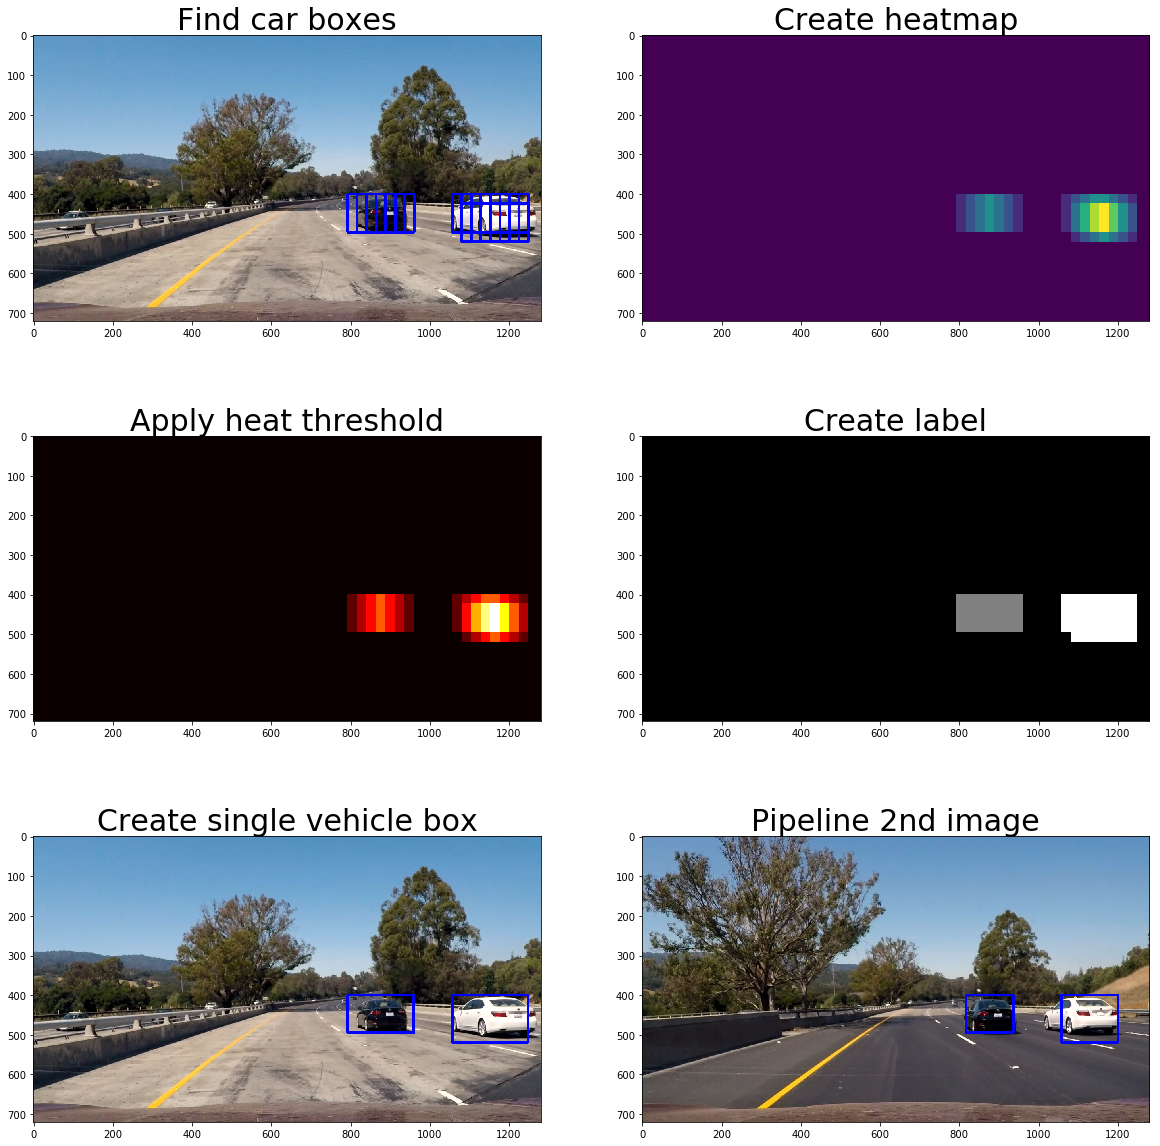

In [21]:
ystart = 400
ystop = 656
scale = 1.5

test_img = mpimg.imread('./test_images/test1.jpg')
rectangles = find_cars(test_img, scale=scale, ystart=ystart, ystop=ystop,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                            orient=orient)

test_img_rects = draw_boxes(test_img, rectangles)
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, rectangles)
    
# Apply threshold to help remove false positives
heat_thresh = apply_threshold(heat, .75)

# Find final boxes from heatmap using label function
labels = label(heat_thresh)
test_img_heat_rec = draw_labeled_bboxes(np.copy(test_img), labels)


# Visualize 
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,20))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(test_img_rects)
ax1.set_title('Find car boxes', fontsize=30)

ax2.imshow(heat)
ax2.set_title('Create heatmap', fontsize=30)

ax3.imshow(heat_thresh, cmap='hot')
ax3.set_title('Apply heat threshold', fontsize=30,)

ax4.imshow(labels[0], cmap='gray')
ax4.set_title('Create label', fontsize=30)

ax5.imshow(test_img_heat_rec)
ax5.set_title('Create single vehicle box', fontsize=30)

other_test_img = mpimg.imread('./test_images/test6.jpg')
ax6.imshow(pipeline(other_test_img))
ax6.set_title('Pipeline 2nd image', fontsize=30)

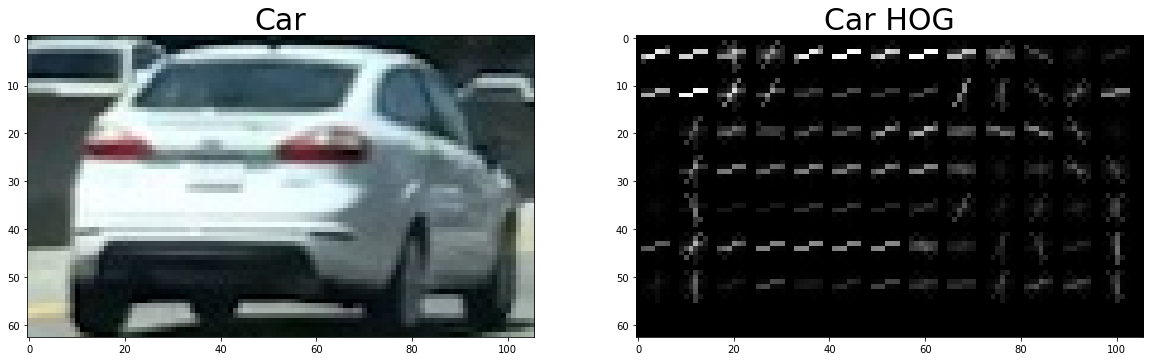

In [46]:
car_img = mpimg.imread('./examples/cutout1.jpg')
f, hog_img = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,20))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car', fontsize=30)

ax2.imshow(hog_img, cmap='gray')
ax2.set_title('Car HOG', fontsize=30)         

In [16]:
# Detect cars in project video and save output
test_output = 'test_video_output_3.mp4'
clip = VideoFileClip('test_video.mp4')
test_clip = clip.fl_image(pipeline)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_output_3.mp4
[MoviePy] Writing video test_video_output_3.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  1.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output_3.mp4 



In [23]:
# Detect cars in project video and save output
test_output = 'project_video_output_4.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(pipeline)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_output_4.mp4
[MoviePy] Writing video project_video_output_4.mp4


100%|█████████▉| 1260/1261 [10:55<00:00,  1.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_4.mp4 

